# Case study: Lorenz attractor

This notebook contains a full TDA pipeline to analyse the transitions of the Lorenz system to a chaotic regime from the stable one and viceversa.

If you are looking at a static version of this notebook and would like to run its contents, head over to [github](https://github.com/giotto-ai/giotto-tda/blob/master/examples/lorenz_attractor.ipynb).

**License: AGPLv3**

## Import libraries
The first step consists in importing relevant *gtda* components and other useful libraries or modules.

In [1]:
# Import the gtda modules
from gtda.time_series import Resampler, TakensEmbedding, SlidingWindow, PermutationEntropy
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance

from gtda.pipeline import Pipeline

import numpy as np
from sklearn.metrics import pairwise_distances

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# gtda plotting functions
from gtda.plotting import plot_heatmap

# Import data from openml
import openml

In [2]:
# Plotting functions
from gtda.plotting import plot_diagram, plot_betti_surfaces
from gtda.plotting import plot_point_cloud

## Setting up the Lorenz attractor simulation

In the next block we set up all the parameters of the Lorenz system and we define also the instants at which the regime (stable VS chaotic) changes.

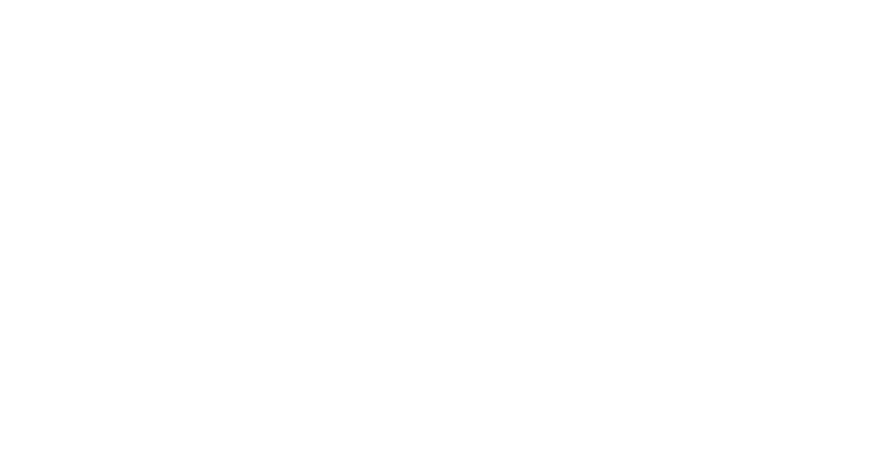

(4942, 4)


In [5]:
# Plotting the trajectories of the Lorenz system
from openml.datasets.functions import get_dataset

point_cloud = get_dataset(42182).get_data(dataset_format='array')[0]
plot_point_cloud(point_cloud)
print(point_cloud.shape)

In [4]:
# Selecting the z-axis and the label rho
X = point_cloud[:,2]
y = point_cloud[:,3]

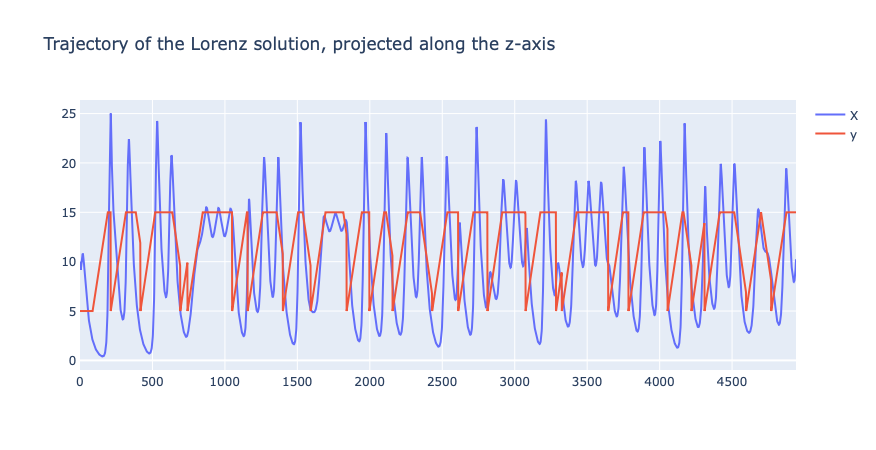

In [22]:
fig = px.line(title='Trajectory of the Lorenz solution, projected along the z-axis')
fig.add_scatter(y=X, name='X')
fig.add_scatter(y=y, name='y')
fig.show()

## Resampling the time series

It is important to find the correct time scale at which key signals take place. Here we propose one possible resampling period: *10h*. Recall that the unit time is *1h*. The resampler method is used to perform the resampling.

In [23]:
period = 10
periodicSampler = Resampler(period=period)

X_sampled, y_sampled = periodicSampler.fit_transform_resample(X, y)

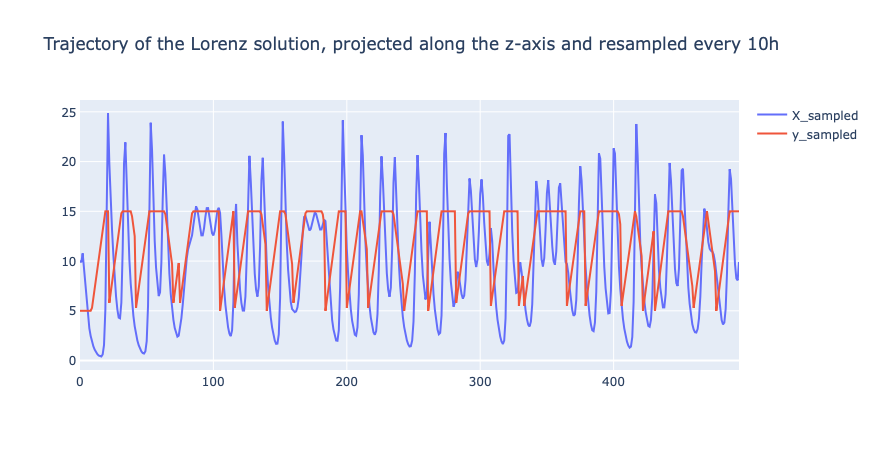

In [24]:
fig = px.line(title='Trajectory of the Lorenz solution, projected along the z-axis and resampled every 10h')
fig.add_scatter(y=X_sampled.flatten(), name='X_sampled')
fig.add_scatter(y=y_sampled, name='y_sampled')
fig.show()

## Takens Embedding

In order to obtain meaningful topological features from a time series, we use a delayed-time embedding technique, invented by F. Takens in the late 1960s.
The idea is simple: given a time series $X(t)$, one can extract a sequence of vectors of the form $X_i := [(X(t_i)), X(t_i + 2 \tau), ..., X(t_i + M \tau)]$.
The difference between $t_i$ and $t_{i-1}$ is called *stride*.

$M$ and $\tau$ are optimized automatically in this example (they can be set by the user if needed).

In [39]:
embedding_dimension = 10
time_delay = 3
TE = TakensEmbedding(
    parameters_type='search', dimension=embedding_dimension, time_delay=time_delay)

In [42]:
TE.fit(X_sampled)
time_delay_ = TE.time_delay_
embedding_dimension_ = TE.dimension_

print('Optimal embedding time delay based on mutual information: ', time_delay_)
print('Optimal embedding dimension based on false nearest neighbors: ', embedding_dimension_)

Optimal embedding time delay based on mutual information:  3
Optimal embedding dimension based on false nearest neighbors:  10


In [43]:
X_embedded, y_embedded = TE.transform_resample(X_sampled, y_sampled)

We can also "localise" our Takens embedding procedure to multiple sliding windows over the data, rather than over the whole time series as we just did. The result is therefore a "time series of point clouds" with possibly interesting topologies, which we will be able to feed directly to our homology transformers.

In [44]:
window_width = 40
window_stride = 5
SW = SlidingWindow(width=window_width, stride=window_stride)

X_windows, y_windows = SW.fit_transform_resample(X_embedded, y_embedded)

We can plot the Takens embedding of a specific window either by using `plot_point_cloud`, or by using the `plot` method of `SlidingWindow`, as follows (*note*: when `embedding_dimension > 3`, only the first three coordinates are plotted!):

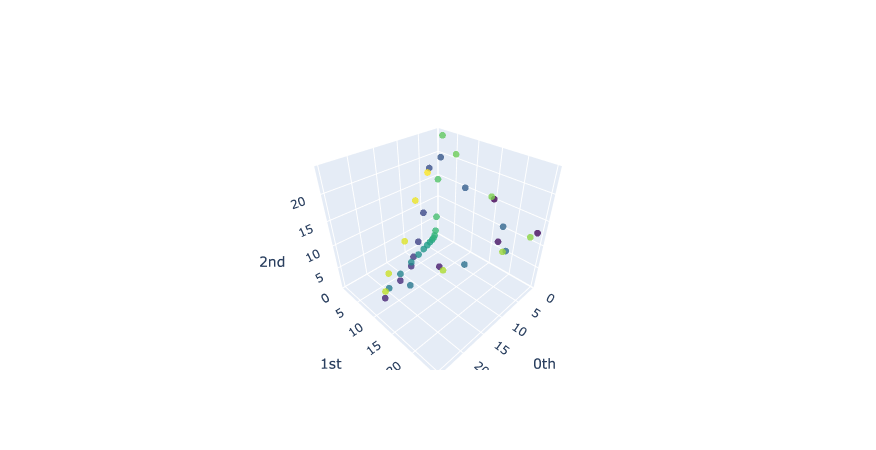

In [45]:
window_number = 3
SW.plot(X_windows, sample=window_number)

For comparison, here is the portion of time series containing the data which originates this point cloud. Notice the quasi-periodicity, corresponding to the loop in the point cloud.

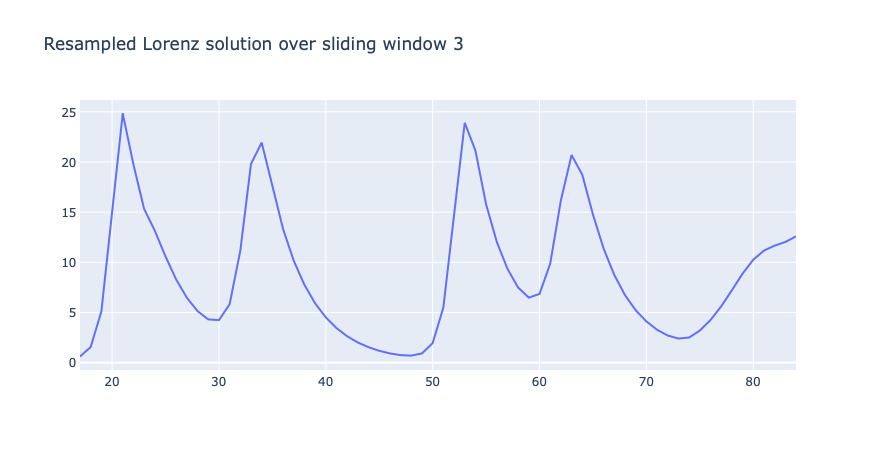

In [16]:
embedded_begin, embedded_end = SW._slice_windows(X_embedded)[window_number]
window_indices = np.arange(embedded_begin, embedded_end + time_delay_ * (embedding_dimension_ - 1))
fig = px.line(title=f'Resampled Lorenz solution over sliding window {window_number}')
fig.add_scatter(x=window_indices, y=X_sampled[window_indices], name='X_sampled')
fig.show()

## Persistence diagram
The topological information in the embedding is synthesised via the persistence diagram. The horizontal axis corresponds to the moment in which a homological generator is born, while the vertical axis corresponds to the moments in which a homological generator dies.
The generators of the homology groups (at given rank) are colored differently.

In [17]:
homology_dimensions = (0, 1, 2)
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=100, homology_dimensions=homology_dimensions)

X_diagrams = VR.fit_transform(X_windows)

We can plot the persistence diagram for the embedding of the same sliding window as before. One way is using the `plot_diagram` function.

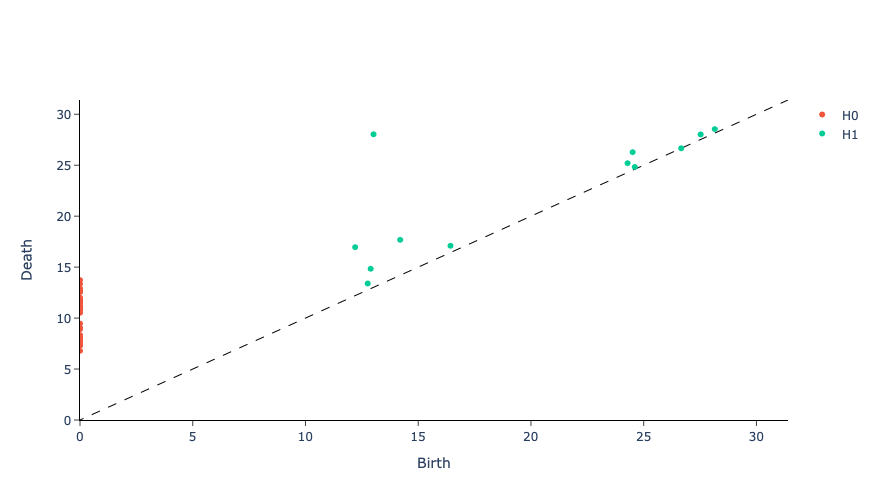

In [19]:
plot_diagram(X_diagrams[window_number])

Alternatively, we could have used the `plot` method of `VietorisRipsPersistence` as follows:
```
VR.plot(X_diagrams, sample=window_number)
```

## Scikit-learn–style pipeline

One of the advantages of `giotto-tda` is the compatibility with `scikit-learn`. It is possible to set up and run a full pipeline such as the one above in a few lines:

In [20]:
# Steps of the Pipeline
steps = [
    ('sampling', periodicSampler),
    ('embedding', TE),
    ('window', SW),
    ('diagrams', VR)
]

# Define the Pipeline
pipeline = Pipeline(steps)

# Run the pipeline
X_diagrams = pipeline.fit_transform(X)

The final result is the same as before:

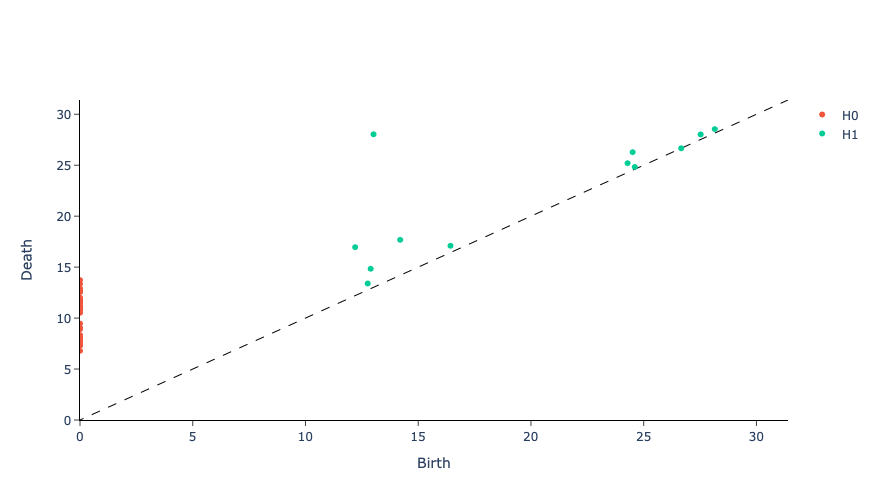

In [21]:
plot_diagram(X_diagrams[window_number])

## Rescaling the diagram

Rescaling a diagram means normalizing points such that the maximum "bottleneck distance" from the *empty diagram* (by default, across all homology dimensions) is equal to one. Notice that this means the birth and death scales are modified. We can use `Scaler` as follows:

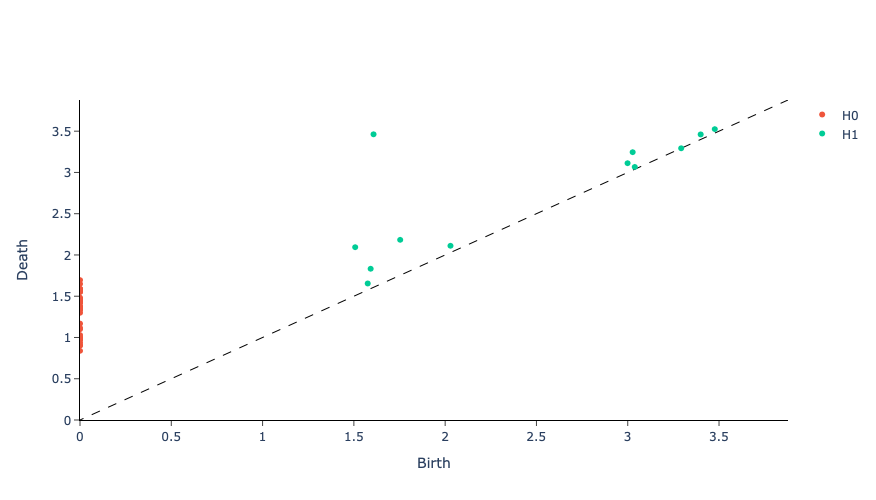

In [22]:
diagramScaler = Scaler()

X_scaled = diagramScaler.fit_transform(X_diagrams)

diagramScaler.plot(X_scaled, sample=window_number)

## Filtering diagrams

Filtering a diagram means eliminating the homology generators whose lifespan is considererd too short to be significant. We can use `Filtering` as follows:

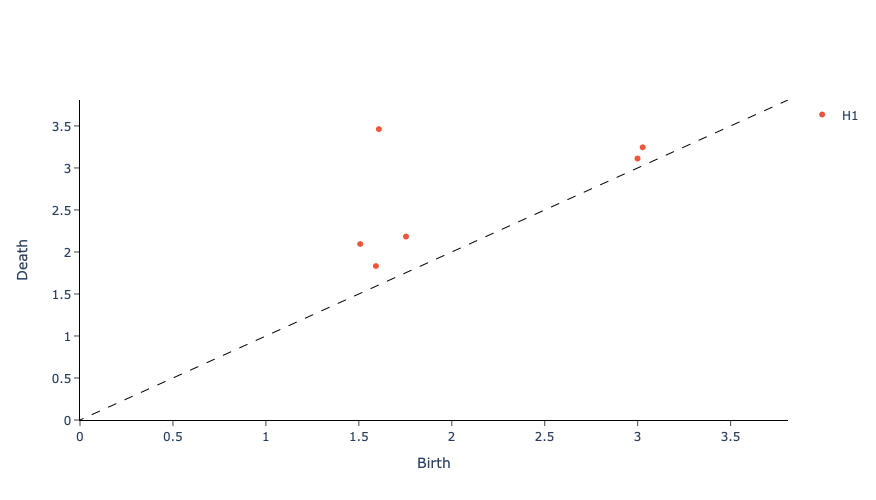

In [23]:
diagramFiltering = Filtering(epsilon=0.1, homology_dimensions=(1, 2))

X_filtered = diagramFiltering.fit_transform(X_scaled)

diagramFiltering.plot(X_filtered, sample=window_number)

We can add the steps above to our pipeline:

In [24]:
steps_new = [
    ('scaler', diagramScaler),
    ('filtering', diagramFiltering)
]

pipeline_filter = Pipeline(steps + steps_new)

X_filtered = pipeline_filter.fit_transform(X)

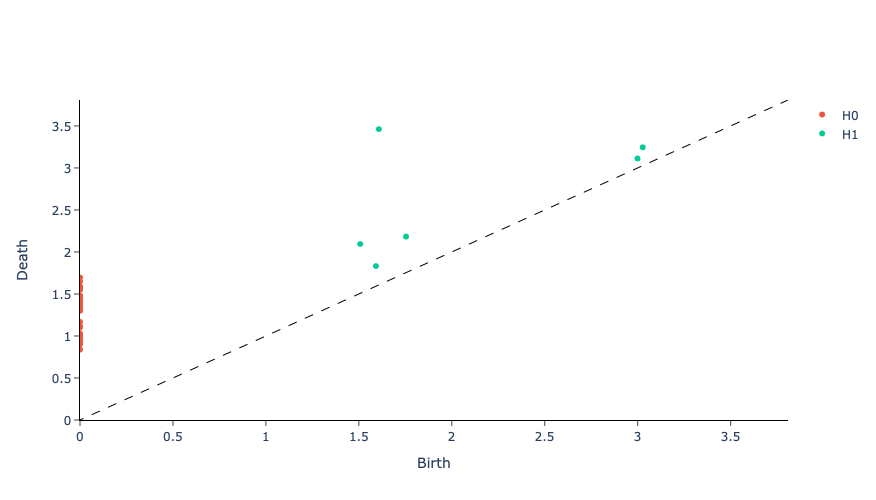

In [25]:
plot_diagram(X_filtered[window_number])

## Persistence entropy

In this section we show how to compute the *entropy* of persistence diagrams.

In [26]:
PE = PersistenceEntropy()

X_persistence_entropy = PE.fit_transform(X_scaled)

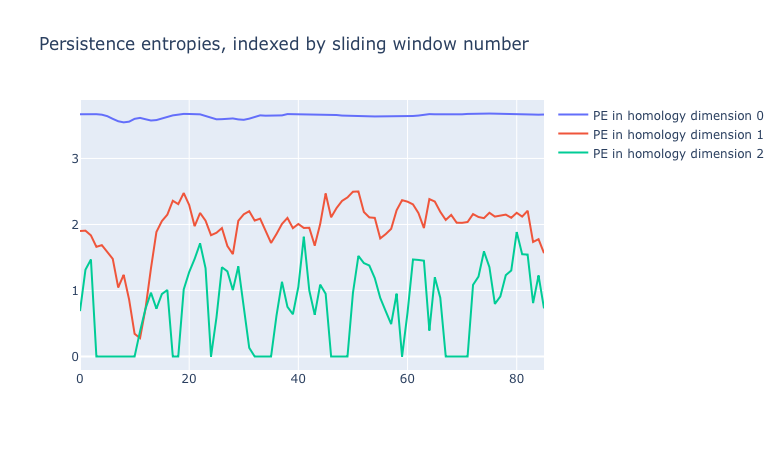

In [27]:
fig = px.line(title='Persistence entropies, indexed by sliding window number')
for dim in range(X_persistence_entropy.shape[1]):
    fig.add_scatter(y=X_persistence_entropy[:, dim], name=f'PE in homology dimension {dim}')
fig.show()

## Betti Curves

In this section we show how to compute the Betti curves of a persistence diagram. We also show the plot of the Betti surface, i.e. the time-stack of the Betti curves.

In [28]:
BC = BettiCurve()

X_betti_curves = BC.fit_transform(X_scaled)

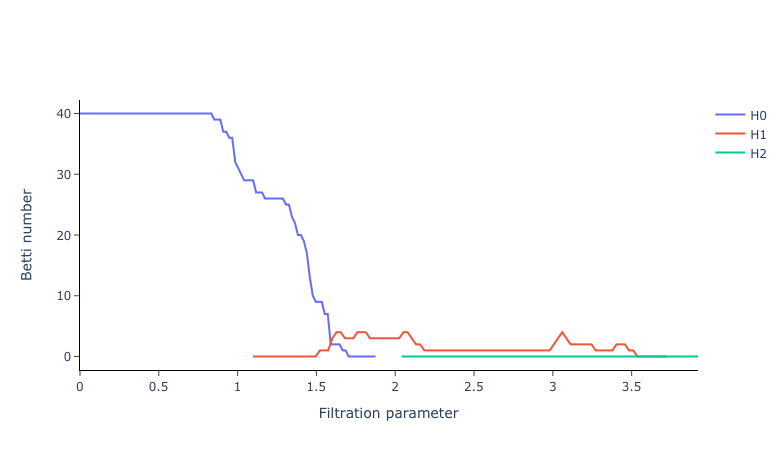

In [29]:
BC.plot(X_betti_curves, sample=window_number)

## Distances among diagrams

In this section we show how to compute several notions of distances among persistence diagrams.

In each case, we will obtain distance matrices whose i-th row encodes the distance of the i-th diagram from all the others.

We start with the so-called "landscape $L^2$ distance": when the parameter `order` is `None`, the output is one distance matrix per sample and homology dimension.

In [30]:
p_L = 2
n_layers = 5
PD = PairwiseDistance(
    metric='landscape', metric_params={'p': p_L, 'n_layers': n_layers, 'n_bins': 1000}, order=None)

X_distance_L = PD.fit_transform(X_diagrams)
print(X_distance_L.shape)

(86, 86, 3)


This is what distances in homology dimension 0 look like:

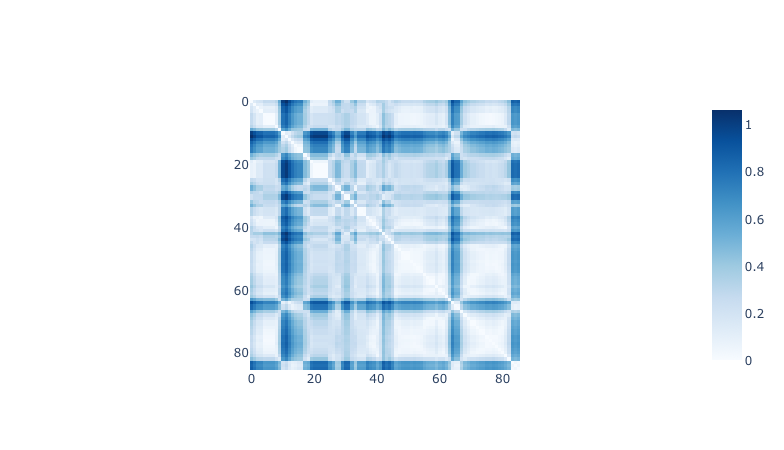

In [32]:
plot_heatmap(X_distance_L[:, :, 0], colorscale='blues')

We now change metric and compute the "$2$-Wasserstein distances" between the diagrams. This one takes longer to compute!

In [33]:
p_W = 2
PD = PairwiseDistance(
    metric='wasserstein', metric_params={'p': p_W, 'delta': 0.1}, order=None)

X_distance_W = PD.fit_transform(X_diagrams)

And again this is what distances in homology dimension 0 look like:

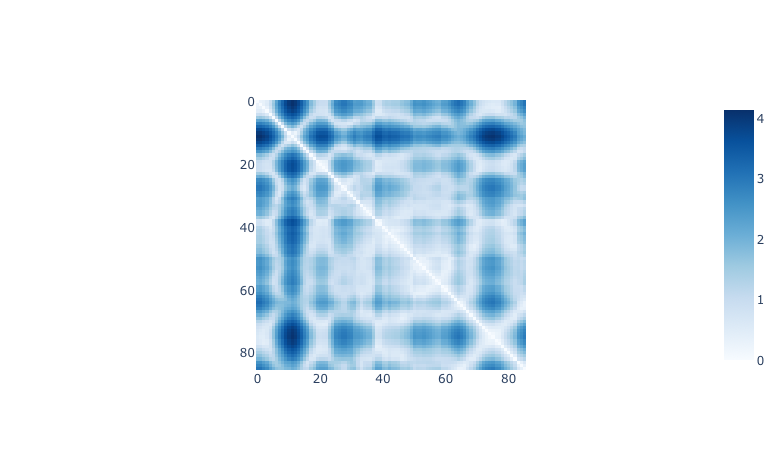

In [34]:
plot_heatmap(X_distance_W[:, :, 0], colorscale='blues')

Notice that how dramatically things can change when the metrics are modified.

## New distances in the embedding space: kNN graphs and geodesic distances

We propose here a new way to compute distances between points in the embedding space. Instead of considering the Euclidean distance in the Takens space, we propose to build a $k$-nearest neighbors graph and then use the geodesic distance on such graph.

In [35]:
n_neighbors = 3
kNN = KNeighborsGraph(n_neighbors=n_neighbors)

X_kNN = kNN.fit_transform(X_windows)

Given the graph embedding, the natural notion of distance between vertices corresponds to the lengths of the shortest path connecting two vertices. This is also known as *graph geodesic distance*. We compute it and plot it for our chosen window number.

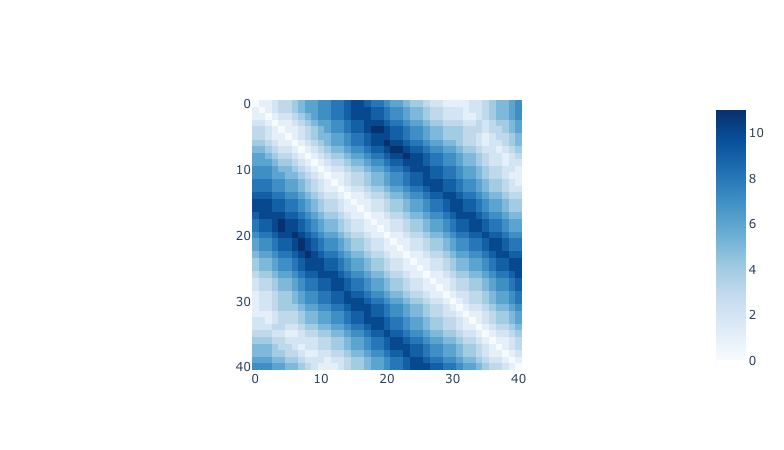

In [36]:
GGD = GraphGeodesicDistance()

GGD.fit_transform_plot(X_kNN, sample=window_number);

For comparison, this is what the ordinary pairwise Euclidean distance matrix looks like for the same window:

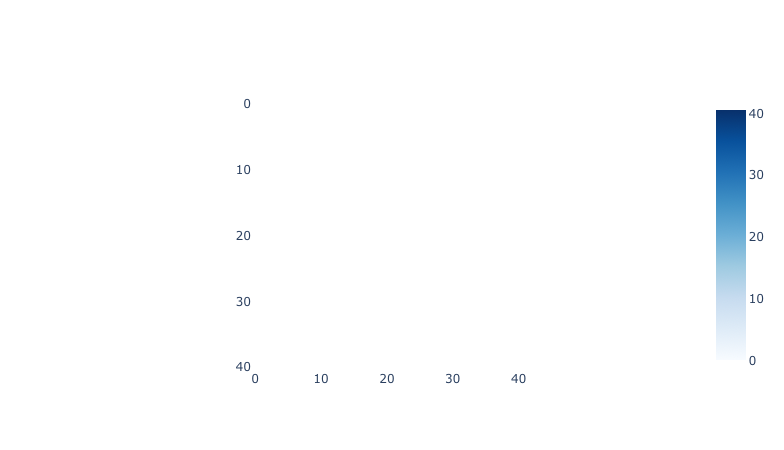

In [37]:
plot_heatmap(pairwise_distances(X_windows[window_number]), colorscale='blues')

This is what the first few steps (before scaling and filtering) of the pipeline described above would be if you'd like persistence diagrams to be obtained using this new distance instead. Notice that we have to pass `metric='precomputed'` to the `VietorisRipsPersistence` constructor this time, because the input already consists of distance matrices:

In [38]:
# Steps of the Pipeline
steps = [
    ('sampling', periodicSampler),
    ('embedding', TE),
    ('window', SW),
    ('kNN_graph', kNN),
    ('graph_geo_distance', GGD),
    ('diagrams', VietorisRipsPersistence(
        metric='precomputed', max_edge_length=100, homology_dimensions=homology_dimensions))
]

# Define the Pipeline
pipeline = Pipeline(steps)

# Run the pipeline
X_diagrams = pipeline.fit_transform(X)

Let's look at the persistence diagrams obtained with this new distance:

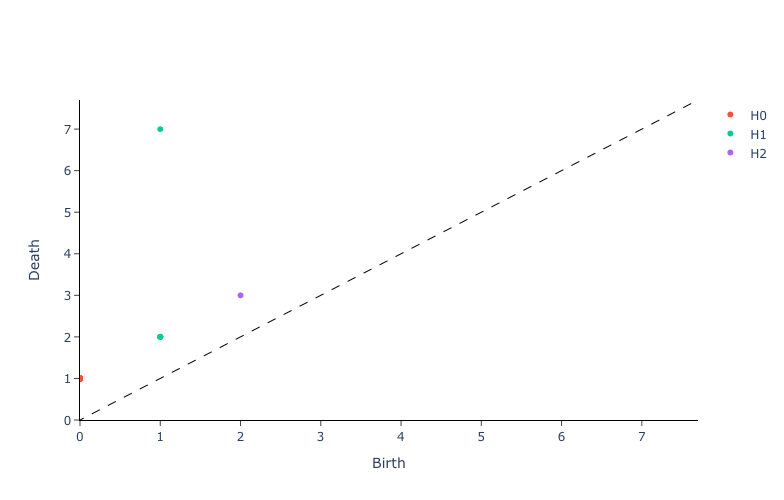

In [39]:
plot_diagram(X_diagrams[window_number])